In [1]:
from primitives.primitives import *
from cirq import Circuit, LineQid, measure, sample, Simulator
from scipy.linalg import expm
import matplotlib.pyplot as plt
from numpy.linalg import eig
import re
from scipy import sparse


simulator = Simulator()

## t-V model definition

One-dimensional spinless t-V model (range=1):

$H = -t \sum_{i=1}^{L} \left( c_i^\dagger c_{i+1} + h.c.\right) + V \sum_{i=1}^L n_i n_{i+1}$

In the 2D case we have to define horizontal and vertical hopping operators.

### Horizontal hopping operators

$H_x^{hop} (i, i+1) = i \Gamma^1_{i} \Gamma^2_{i+1} \left(\tilde \Gamma_i -\tilde\Gamma_{i+1}\right)$

In [2]:
x_hop_matrix = 1j * TensorProduct(sy_gamma_1 * sy_gamma_5, sy_gamma_2) - 1j * TensorProduct(sy_gamma_1, sy_gamma_2 * sy_gamma_5)
class HopXGate(Gate):
    """Horizontal hopping gate."""
    def _qid_shape_(self):
        return (4, 4)
    def _unitary_(self):
        return np.array(x_hop_matrix)
    def _circuit_diagram_info_(self, args):
        return ["H_x(r)", "H_x(r+1)"]
x_hop_matrix

Matrix([
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0, -2.0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0, 2.0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0, 2.0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0, -2.0,   0, 0],
[0,    0, 2.0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0, -2.0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0, -2.0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,  

### Vertical hopping operators

$H_y^{hop} (i, i+1) = i \Gamma^3_{i} \Gamma^4_{i+1} \left(\tilde \Gamma_i -\tilde\Gamma_{i+1}\right)$

In [3]:
y_hop_matrix = 1j * TensorProduct(sy_gamma_3 * sy_gamma_5, sy_gamma_4) - 1j * TensorProduct(sy_gamma_3, sy_gamma_4 * sy_gamma_5)
class HopYGate(Gate):
    """Vertical hopping gate."""
    def _qid_shape_(self):
        return (4, 4)
    def _unitary_(self):
        return np.array(y_hop_matrix)
    def _circuit_diagram_info_(self, args):
        return ["H_y(r)", "H_y(r+1)"]
y_hop_matrix

Matrix([
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0, 2.0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0, 2.0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0, 2.0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0, 2.0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0, -2.0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0, -2.0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0, -2.0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   

### Number operator

$n_i = \frac{1}{2} - \frac{1}{2}\tilde \Gamma_i$

In [4]:
number_matrix = 0.5 * sy_id - 0.5 * sy_gamma_5
class NumberGate(Gate):
    """Number gate."""
    def _qid_shape_(self):
        return (4,)
    def _unitary_(self):
        return np.array(number_matrix)
    def _circuit_diagram_info_(self, args):
        return ["n(r)"]
number_matrix

Matrix([
[0,   0,   0, 0],
[0, 1.0,   0, 0],
[0,   0, 1.0, 0],
[0,   0,   0, 0]])

### Evolution gates

In [5]:
def evolve_gate(gate):
    class evolved(Gate):
        def __init__(self, C=1, t=0.1):
            self.C = C  # coefficient
            self.t = t  # evolution time
            self.matrix = expm(np.array(-1j * self.t * self.C * gate()._unitary_(), dtype=np.complex128))
            super()
        def _qid_shape_(self):
            return gate()._qid_shape_()
        def _circuit_diagram_info_(self, args):
            return gate()._circuit_diagram_info_(args)
        def _unitary_(self):
            return self.matrix
    return evolved

# example:
evolution_hopping = evolve_gate(HopYGate)(C = 1, t = 0.5)

## Evolving a state

In [6]:
def evolve(qubits, temps, initial=None, t=1, V=0, exact=False, shots=10):

    if initial is None:
        initial = []
    
    if V != 0:
        evolution_number = evolve_gate(NumberGate)(t = temps[1]-temps[0])

    if len(temps) > 1:
        evolution_horizontal_hop = evolve_gate(HopXGate)(C=t, t = temps[1]-temps[0])
        evolution_vertical_hop = evolve_gate(HopYGate)(C=t, t = temps[1]-temps[0])

    results = []
    
    evolution_circuit = []
    for idx, t in enumerate(temps):

        if t != 0:
            # on site part
            if V != 0:
                for qubit in qubits.flatten():
                    evolution_circuit.append(evolution_number(qubit))
    
            rows, cols = qubits.shape
            for r_idx, row in enumerate(qubits):
                for q_idx, qubit in enumerate(row):

                    # THIS IS WITHOUT PERIODIC BOUNDARIES
                    if r_idx != rows - 1:
                        qubit_2 = qubits[r_idx+1][q_idx]
                        evolution_circuit.append(evolution_horizontal_hop(qubit, qubit_2))
                    if q_idx != cols - 1:
                        qubit_2 = qubits[r_idx][q_idx+1]
                        evolution_circuit.append(evolution_horizontal_hop(qubit, qubit_2))

                    '''
                    # THIS IS WITH PERIODIC BOUNDARIES

                    # horizontal hopping
                    qubit_2 = row[0] if q_idx == columns-1 else row[q_idx+1]
                    evolution_circuit.append(evolution_horizontal_hop(qubit, qubit_2))
                    # vertical hopping
                    qubit_2 = qubits[0][q_idx] if r_idx == rows-1 else qubits[r_idx+1][q_idx]
                    evolution_circuit.append(evolution_vertical_hop(qubit, qubit_2))
                    '''
                    
        if not exact:
            measures = [measure(qubit, key=f"q{idx}") for idx, qubit in enumerate(qubits.flatten())]
            circuit = Circuit([*initial, *evolution_circuit, *measures])
            results.append((circuit, sample(circuit, repetitions=shots)))
        else:
            circuit = Circuit([*initial, *evolution_circuit])
            results.append((circuit, simulator.simulate(circuit)))
            
    return results

In [7]:
def from_measurements_to_state(a):
    num_qubits = len(a.measurements)
    state_array = np.zeros(4 ** num_qubits)
    for idx in range(a.repetitions):
        state_idx = 0
        for q in a.measurements:
            q_idx = int(q[1:])
            state_idx += a.measurements[q][idx][0] * (4**(num_qubits - q_idx - 1))
        state_array[state_idx] += 1

    state_array = np.array(state_array)
    state_array /= np.sum(state_array)
    
    return state_array

In [8]:
# Checking if the constraint hold

def increment_key(key, num=8):
    if key == "":
        return "0"*num
    idx = -1
    while True:
        if -idx > len(key):
            print("This should not be reached!")
            return key
        if int(key[idx]) < 3:
            key = list(key)
            key[idx] = str(int(key[idx])+1)
            return "".join(key)
        key = list(key)
        key[idx] = "0"
        key = "".join(key)
        idx -= 1
        
def state_to_dict(state):
    res_dict = {}
    state_key = ""
    
    for el in state:
        state_key = increment_key(state_key)
        res_dict[state_key] = el
        
    return res_dict

def extract_subspace(state, qubits = None):
    if qubits is None:
        qubits = [0, 1, 4, 5]
    res_dict = state_to_dict(state)
    new_dict = {}
    for key in res_dict:
        temp = [key[q] for q in qubits]
        restricted_key = "".join(temp)
        if restricted_key not in new_dict:
            new_dict[restricted_key] = 0
        new_dict[restricted_key] += res_dict[key]**2

    state_array = np.array(list(new_dict.values()))
    
    sum = 0
    for val in state_array:
        sum += val**2
    state_array /= np.sqrt(sum)
    
    return state_array

## Constraints

The constraint is (for every plaquette):
$\Gamma^{23}_{r}\Gamma^{23}_{r+x}\Gamma^{23}_{r+x+y}\Gamma^{23}_{r+y} \tilde\Gamma_r \tilde\Gamma_{r+x+y}= I$

We call the first operator G

In [9]:
gamma_23 = sy_gamma_2 * sy_gamma_3

G = np.array(TensorProduct(sy_gamma_1*sy_gamma_3, sy_gamma_2*sy_gamma_3, sy_gamma_4*sy_gamma_2, sy_gamma_1*sy_gamma_4))

class Project_Constraintb(Gate):
    """Gate that prepare an initial state, from the coefficients."""

    def _qid_shape_(self):
        return (4, 4, 4, 4)

    def _unitary_(self):
        return (np.eye(4**4) - G)/2   # IS THIS THE CORRECT FORM?

    def _circuit_diagram_info_(self, args):
        return ["P", "P", "P", "P"]

class Project_Constraint(Gate):
    """Gate that prepare an initial state, from the coefficients."""

    def _qid_shape_(self):
        return (4, 4, 4, 4)

    def _unitary_(self):
        return (np.eye(4**4) + G)/2   # IS THIS THE CORRECT FORM?

    def _circuit_diagram_info_(self, args):
        return ["P", "P", "P", "P"]
Project_Constraint()._unitary_()

array([[0.500000000000000, 0, 0, ..., 0, 0, -0.500000000000000],
       [0, 0.500000000000000, 0, ..., 0, 0.500000000000000, 0],
       [0, 0, 0.500000000000000, ..., 0.500000000000000, 0, 0],
       ...,
       [0, 0, 0.500000000000000, ..., 0.500000000000000, 0, 0],
       [0, 0.500000000000000, 0, ..., 0, 0.500000000000000, 0],
       [-0.500000000000000, 0, 0, ..., 0, 0, 0.500000000000000]],
      dtype=object)

### Add fermions

The creation operator for pairs of fermions is:

$f^\dagger_r f^\dagger_{r+x}=i \Gamma^1_r \Gamma^2_{r+x} \frac{(I + \tilde\Gamma_r)(I + \tilde \Gamma_{r+x})}{4}$

In [10]:
class AddPair(Gate):
    """Add pair of fermions (r)+(r+x)."""
    
    def _qid_shape_(self):
        return (4, 4)

    def _unitary_(self):
        return np.array(1j * (1/4) * TensorProduct(sy_gamma_1, sy_gamma_2) * TensorProduct(sy_id + sy_gamma_5, sy_id + sy_gamma_5))

    def _circuit_diagram_info_(self, args):
        return ["f+", "f+"]

AddPair()._unitary_()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.00000000000000],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.00000000000000, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1.00000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [-1.00000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

## Evolving a 4x2 lattice

In [11]:
rows = 2
columns = 4

qudits = np.array(LineQid.range(rows * columns, dimension=4)).reshape(rows, columns)
temps = np.arange(0, 2, 1)

# initial circuit that ensures that the correct subspace is used (really?)
initial_circuit = [
    #GateId()(qudits[0][0], qudits[0][1], qudits[1][1], qudits[1][0]),
    Project_Constraint()(qudits[0][0], qudits[0][1], qudits[1][1], qudits[1][0]),
    Project_Constraint()(qudits[0][1], qudits[0][2], qudits[1][2], qudits[1][1]),
    Project_Constraint()(qudits[0][2], qudits[0][3], qudits[1][3], qudits[1][2]),
    
    #Project_Constraint()(qubits[1][0], qubits[1][1], qubits[0][1], qubits[0][0]),
    #Project_Constraint()(qubits[1][1], qubits[1][2], qubits[0][2], qubits[0][1]),
    #Project_Constraint()(qubits[1][2], qubits[1][3], qubits[0][3], qubits[0][2]),
    #Project_Constraint()(qubits[0][3], qubits[0][0], qubits[0][1], qubits[1][3]),

    AddPair()(qudits[0][0], qudits[0][1]),
    #AddPair()(qubits[1][0], qubits[1][1]),

]

# results is a list of tuples, every tuple contains the circuit and the result shots
exact = True
results = evolve(qudits, temps, initial_circuit, shots=10, exact=exact)
if exact:
    result_states = [res[1].state_vector() for res in results]
else:
    result_states = [from_measurements_to_state(res[1]) for res in results]

In [12]:
results[0][0]

0 (d=4): ───P───────f+───
            │       │
1 (d=4): ───P───P───f+───
            │   │
2 (d=4): ───┼───P───P────
            │   │   │
3 (d=4): ───┼───┼───P────
            │   │   │
4 (d=4): ───P───┼───┼────
            │   │   │
5 (d=4): ───P───P───┼────
                │   │
6 (d=4): ───────P───P────
                    │
7 (d=4): ───────────P────

In [13]:
test = results[0][1]
test

measurements: (no measurements)

qubits: (cirq.LineQid(0, dimension=4), cirq.LineQid(1, dimension=4), cirq.LineQid(5, dimension=4), cirq.LineQid(4, dimension=4), cirq.LineQid(2, dimension=4), cirq.LineQid(6, dimension=4), cirq.LineQid(3, dimension=4), cirq.LineQid(7, dimension=4))
output vector: -0.125|11330000⟩ + 0.125|11333333⟩ + 0.125|12030033⟩ + 0.125|12033300⟩ - 0.125|21300033⟩ - 0.125|21303300⟩ - 0.125|22000000⟩ + 0.125|22003333⟩

phase:
output vector: |⟩

In [14]:
def expectation_value(result, qudits, operator):
    rho = test.density_matrix_of(qudits)
    
    srho = sparse.csr_matrix(np.array(rho, dtype=np.complex128)) 
    srho /= srho.trace()
    shop = sparse.csr_matrix(np.array(operator, dtype=np.complex128))
    val = srho * shop
    
    return val.trace()

# operator n
operator = np.array(0.5 * (sy_id - sy_gamma_5))
expectation_value(results[0][1], [qudits[0][0]], operator)

(1+0j)

### Check operator evolution

(-1.1, 1.1)

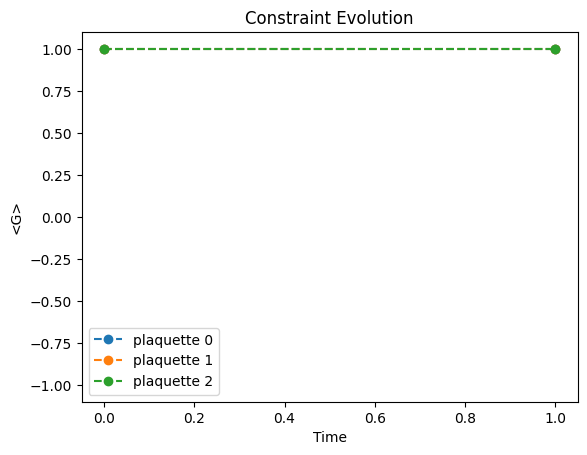

In [16]:
plaqs = [
    [qudits[0][0], qudits[0][1], qudits[1][0], qudits[1][1]],
    [qudits[0][1], qudits[0][2], qudits[1][1], qudits[1][2]],
    [qudits[0][2], qudits[0][3], qudits[1][2], qudits[1][3]]
]
# operator G
operator = np.array(TensorProduct(sy_gamma_1*sy_gamma_3, sy_gamma_2*sy_gamma_3, sy_gamma_1*sy_gamma_4, sy_gamma_4*sy_gamma_2))

evol_res = {"0": [], "1": [], "2": []}

for idx, plaquette in enumerate(plaqs):
    for state in results:
        val = expectation_value(state[1], plaquette, operator)
        evol_res[str(idx)].append(np.abs(val))

for i in range(3):
    plt.plot(temps, evol_res[str(i)], "o--", label=f"plaquette {i}")
    
plt.title("Constraint Evolution")
plt.xlabel("Time")
plt.ylabel("<G>")
plt.legend()
plt.ylim(-1.1, 1.1)

# More

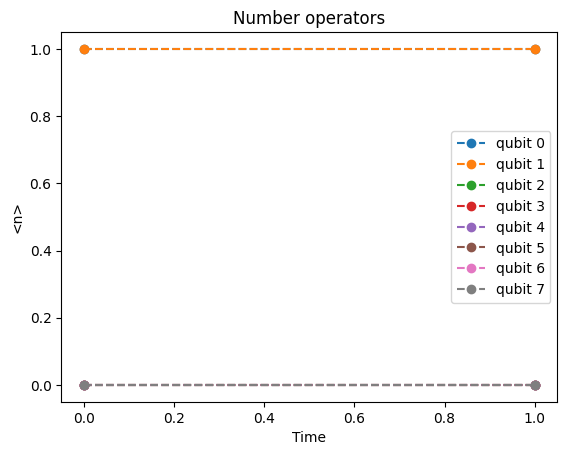

In [17]:
subsystems = [
    [0], [1], [2], [3], [4], [5], [6], [7]
]
num_evol_res = {str(i[0]): [] for i in subsystems}

for idx, sys in enumerate(subsystems):
    for state in results:
        operator =  np.array(0.5 * sy_id - 0.5 * sy_gamma_5)
        val = expectation_value(state, [qudits.flatten()[idx]], operator)
        num_evol_res[str(idx)].append(np.abs(val))
        
for key in num_evol_res:
    plt.plot(temps, num_evol_res[key], "o--", label=f"qubit {key}")
    
plt.title("Number operators")
plt.xlabel("Time")
plt.ylabel("<n>")
plt.legend()